In [1]:
require 'Utils'
require 'nngraph';
require 'loadcaffe'
require 'image'
require 'VGG'
require 'optim'
prototxt = '../../Data/VGG_caffe/VGG_ILSVRC_16_layers_deploy.prototxt'
binary = '../../Data/VGG_caffe/VGG_ILSVRC_16_layers.caffemodel'
net = loadcaffe.load(prototxt, binary);

Successfully loaded ../../Data/VGG_caffe/VGG_ILSVRC_16_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3


conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


In [2]:
input = nn.Identity()():annotate{
   name = 'Conv Layer 1', description = 'Image Features',
   graphAttributes = {color = 'green'}
}
conv1  = net.modules[1]
conv3  = net.modules[3]
conv6  = net.modules[6]
conv8  = net.modules[8]
conv11 = net.modules[11]
conv13 = net.modules[13]
conv15 = net.modules[15]
conv18 = net.modules[18]
conv20 = net.modules[20]
conv22 = net.modules[22]
conv25 = net.modules[25]
conv27 = net.modules[27]
conv29 = net.modules[27]
FC33   = net.modules[33]
FC36   = net.modules[36]
FC39   = net.modules[39]

level_0  = conv1(input):annotate{
   name = 'Conv Layer 1', description = 'Image Features',
   graphAttributes = {color = 'red'}
}
level_1  = conv3(nn.ReLU()(level_0)):annotate{
   name = 'Conv Layer 2', description = 'Image Features',
   graphAttributes = {color = 'blue'}
}
level_2  = conv6(nn.SpatialMaxPooling(2,2,2,2)(nn.ReLU()(level_1))):annotate{
   name = 'Conv Layer 3', description = 'Image Features',
   graphAttributes = {color = 'red'}
}
level_3  = conv8(nn.ReLU()(level_2)):annotate{
   name = 'Conv Layer 3', description = 'Image Features',
   graphAttributes = {color = 'blue'}
}
level_4  = conv11( nn.SpatialMaxPooling(2,2,2,2)(nn.ReLU()(level_3)) ):annotate{
   name = 'Conv Layer 3', description = 'Image Features',
   graphAttributes = {color = 'red'}
}
level_5  = conv13(nn.ReLU()(level_4)):annotate{
   name = 'Conv Layer 3', description = 'Image Features',
   graphAttributes = {color = 'red'}
}
level_6  = conv15(nn.ReLU()(level_5)):annotate{
   name = 'Conv Layer 3', description = 'Image Features',
   graphAttributes = {color = 'blue'}
}
-- We are not using these levels yet. Hence commented
-- level_7 = conv18(nn.SpatialMaxPooling(2,2,2,2)(nn.ReLU()(level_6)))
-- level_8 = conv20(nn.ReLU()(level_7))
-- level_9 = conv22(nn.ReLU()(level_8))
-- level_10 = conv25(nn.SpatialMaxPooling(2,2,2,2)(nn.ReLU()(level_9)))
-- level_11 = conv27(nn.ReLU()(level_10))
-- level_12 = conv29(nn.ReLU()(level_11))
-- level_13 = FC33(nn.View(-1)(nn.SpatialMaxPooling(2,2,2,2)(nn.ReLU()(level_12))))
-- level_14 = FC36(nn.Dropout(0.5)(nn.ReLU()(level_13)))
-- level_15 = FC39(nn.Dropout(0.5)(nn.ReLU()(level_14)))
-- output = nn.SoftMax()(level_15)




In [3]:
dimension = 2
-- Deconvoluting level 3 and level 6
level_3_deconv = nn.SpatialFullConvolution(128, 16, 1, 1, 2, 2, 0, 0, 1, 1)(level_3):annotate{
   name = 'Deconving level 3', description = 'To increase the dimension',
   graphAttributes = {color = 'yellow'}
}
level_6_deconv = nn.SpatialFullConvolution(256, 16, 2, 2, 4, 4, 0, 0, 2, 2)(level_6):annotate{
   name = 'Deconving level 6', description = 'To increase the dimension',
   graphAttributes = {color = 'yellow'}
}
output_VGG = (nn.JoinTable(dimension)({input, level_1, level_3_deconv, level_6_deconv})):annotate{
   name = 'Joining layer', description = 'Joining input, level1, deconved_level3, deconved_level6',
   graphAttributes = {color = 'grey'}
}


-- Building our own network from here. 3 layers
level_6point5 = nn.SpatialBatchNormalization(32)( nn.SpatialConvolution(99, 32, 3, 3, 1, 1, 1, 1)(output_VGG))
level_7 = nn.SpatialMaxPooling(2,2,2,2)(nn.ReLU()( level_6point5 ))

level_7point5 = nn.SpatialBatchNormalization(64)( nn.SpatialConvolution(32, 64, 3, 3, 1, 1, 1, 1)(level_7))
level_8 = nn.SpatialMaxPooling(2,2,2,2)(nn.ReLU()( level_7point5 ))

level_9= nn.Sigmoid()( nn.SpatialConvolution(64, 2, 3, 3, 1, 1, 1, 1)(level_8)):annotate{
   name = 'Final Layer', description = 'Final output. Using Sigmoid',
   graphAttributes = {color = 'purple'}
}

model = nn.gModule({input}, {level_9})
--netsav = model:clone('weight', 'bias', 'running_mean', 'running_std')

graph.dot(model.fg, 'MLP', 'VGGnet')


## Debugging

In [4]:
nngraph.setDebug(true)

local dtype = 'torch.DoubleTensor'
local params, grad_params = model:getParameters()
local crit = nn.MSECriterion():type(dtype)

-- Set up some variables we will use below
local train_loss_history = {}

-- Contains all the meta parameters
local opt = {num_iterations=10, print_every=1, learning_rate=0.0002, 
    batch_size = 2, layers = {3,9}}

--Triming the network will the last required layer 

-- Loss function that we pass to an optim method
local function f(w)
--  assert(w == params)
  grad_params:zero()

  im_batch = get_validation_batch(opt.batch_size)
  x = torch.Tensor(im_batch:size()[1],im_batch:size()[2],224,224)

  for i=1,im_batch:size()[1] do
    x[i] = preprocess(im_batch[i])
  end
  uv_images, y_images = create_yuv_images(im_batch,56,56)
  x, uv_images = x:type(dtype), uv_images:type(dtype)
  local y = uv_images + 0.5

  local scores = model:forward(x)
  local loss   = crit:forward(scores, y)

  -- Run the Criterion and model backward to compute gradients, maybe timing it
  local grad_scores = crit:backward(scores, y)
  model:backward(x, grad_scores)

  return loss, grad_params
end


-- Train the model!
local optim_config = {learningRate = opt.learning_rate}
local num_iterations = opt.num_iterations
for i = 1, num_iterations do

  -- Take a gradient step and maybe print
  -- Note that adam returns a singleton array of losses
  local _, loss = optim.adam(f, params, optim_config)
  table.insert(train_loss_history, loss[1])
  if opt.print_every > 0 and i % opt.print_every == 0 then
    local msg = ' i = %d / %d, loss = %f'
    local args = {msg,  i, num_iterations, loss[1]}
    print(string.format(unpack(args)))
  end
end


 i = 1 / 10, loss = 0.040680	


 i = 2 / 10, loss = 0.026936	


 i = 3 / 10, loss = 0.017390	


 i = 4 / 10, loss = 0.011521	


 i = 5 / 10, loss = 0.007931	


 i = 6 / 10, loss = 0.005560	


 i = 7 / 10, loss = 0.003943	


 i = 8 / 10, loss = 0.002886	


 i = 9 / 10, loss = 0.002235	


 i = 10 / 10, loss = 0.001835	


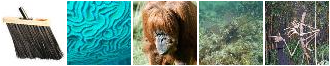

In [5]:
im_batch = get_validation_batch(5)
itorch.image(im_batch)

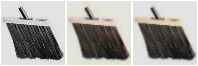

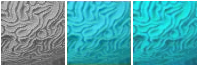

In [6]:
uv_op = model.output - 0.5
for i = 1,2 do
    size = 64
    itorch.image({image.scale(y2rgb(image.rgb2y(im_batch[i])),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_op[i],1)),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i],1)),size,size)})
end

In [7]:
model:clearState()
netsav = model
torch.save('../../model/nngraph_net.t7', netsav)

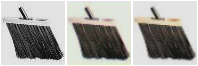

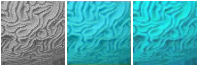

In [8]:
model_load = torch.load('../../model/nngraph_net.t7')
model_load:forward(x)
uv_op_load = model_load.output - 0.5
for i = 1,2 do
    size = 64
    itorch.image({image.scale(y2rgb(image.rgb2y(im_batch[i])),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_op_load[i],1)),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i],1)),size,size)})
end